# Reading the netCDF files in Python

Note: This notebook uses Python 3.

In [1]:
from netCDF4 import Dataset

In [2]:
DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'

In [3]:
rg = Dataset(DATA_DIR + 'data_interpolated.nc')

In [4]:
rg

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): station(537), member(50), time(7306), nchar(36)
    variables(dimensions): int32 station(station), int32 member(member), int32 time(time), float32 t2m_fc(time,member,station), float32 t2m_obs(time,station), float32 station_alt(station), float32 station_lat(station), float32 station_lon(station), float32 station_id(station), |S1 station_loc(station,nchar)
    groups: 

Ok, let's see what's in the file.
- 4 dimensions: station, member, time and nchar (which has something to do with characters... we will check that out later)
- Variables:
    - station(station) == station_id
    - member(member)
    - time(time) *Time in s since 1.1.1970*
    - t2m_fc(time, member, station)
    - t2m_obs(time, station)
    - station_alt(station) *Altitute of station in m*
    - station_lat(station) *Latitude in degrees*
    - station_lon(station)  *Longitude in degrees*
    - station_id(station) == station
    - station_loc(station, nchar)  *Location name*
    
### Let's first check out the time dimension

In [5]:
time = rg.variables['time']
time

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1970-01-01 00:00 UTC
    long_name: valid time of forecasts and observations, UTC
unlimited dimensions: 
current shape = (7306,)
filling on, default _FillValue of -2147483647 used

In [6]:
time[:5]

array([1167739200, 1167782400, 1167825600, 1167868800, 1167912000], dtype=int32)

In [7]:
# convert back to dates (http://unidata.github.io/netcdf4-python/#section7)
from netCDF4 import num2date
dates = num2date(time[:],units='seconds since 1970-01-01 00:00 UTC')
dates[:5]

array([datetime.datetime(2007, 1, 2, 12, 0),
       datetime.datetime(2007, 1, 3, 0, 0),
       datetime.datetime(2007, 1, 3, 12, 0),
       datetime.datetime(2007, 1, 4, 0, 0),
       datetime.datetime(2007, 1, 4, 12, 0)], dtype=object)

So dates are in 12 hour intervals. Which means that since we downloaded 36/48h forecasts: the 12UTC dates correspond to the 36 hour fcs and the following 00UTC dates correspond to the same forecast at 48 hour lead time. For post processing we should maybe split these. 

### Next up: What are all these station_??? variables

In [8]:
station = rg.variables['station']
station

<class 'netCDF4._netCDF4.Variable'>
int32 station(station)
    units: station_ID
    long_name: station
unlimited dimensions: 
current shape = (537,)
filling on, default _FillValue of -2147483647 used

In [9]:
station[:5]

array([ 3, 44, 71, 73, 78], dtype=int32)

In [10]:
station_id = rg.variables['station_id']
station_id

<class 'netCDF4._netCDF4.Variable'>
float32 station_id(station)
    _FillValue: nan
    long_name: station ID
unlimited dimensions: 
current shape = (537,)
filling on

In [11]:
station_id[:5]

array([  3.,  44.,  71.,  73.,  78.], dtype=float32)

In [12]:
import numpy as np
np.array_equal(station[:], station_id[:])

True

So the station and station id variable are the same.

In [13]:
station_alt = rg.variables['station_alt']
station_alt

<class 'netCDF4._netCDF4.Variable'>
float32 station_alt(station)
    units: m
    _FillValue: nan
    long_name: altitude of station
unlimited dimensions: 
current shape = (537,)
filling on

In [14]:
station_alt[:5]

array([ 202.,   44.,  759.,  340.,   65.], dtype=float32)

In [15]:
station_loc = rg.variables['station_loc']
station_loc

<class 'netCDF4._netCDF4.Variable'>
|S1 station_loc(station, nchar)
    long_name: location of station
unlimited dimensions: 
current shape = (537, 36)
filling on, default _FillValue of   used

In [16]:
station_loc[0]

masked_array(data = [b'A' b'a' b'c' b'h' b'e' b'n' -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- --],
             mask = [False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True],
       fill_value = b'')

Ahhhh, Aachen :D
So this leads me to believe that the station numbering is done by name.

In [17]:
station_lon = rg.variables['station_lon']
station_lat = rg.variables['station_lat']
station_lon

<class 'netCDF4._netCDF4.Variable'>
float32 station_lon(station)
    units: degrees east
    _FillValue: nan
    long_name: longitude of station
unlimited dimensions: 
current shape = (537,)
filling on

In [18]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/home/s/S.Rasp/.conda/envs/py3/lib/python3.4/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


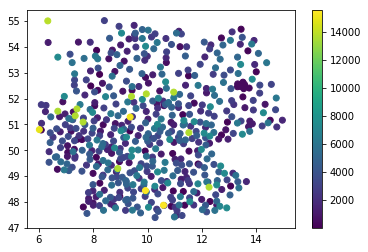

In [22]:
plt.scatter(station_lon[:], station_lat[:], c = station_id[:])
plt.colorbar()

Wohooo, Germany!

### Member variable

In [23]:
members = rg.variables['member']
members

<class 'netCDF4._netCDF4.Variable'>
int32 member(member)
    units: member_number
    long_name: member
unlimited dimensions: 
current shape = (50,)
filling on, default _FillValue of -2147483647 used

In [24]:
members[:5]

array([1, 2, 3, 4, 5], dtype=int32)

### Temperature forecasts and observations

In [25]:
tfc = rg.variables['t2m_fc']
tfc

<class 'netCDF4._netCDF4.Variable'>
float32 t2m_fc(time, member, station)
    units: deg_C
    _FillValue: nan
    long_name: interpolated t2m ensemble forecast
unlimited dimensions: 
current shape = (7306, 50, 537)
filling on

In [26]:
tfc[0, :, 0]

array([ 3.71734357,  4.00520658,  4.33275175,  3.8971622 ,  4.28613043,
        3.90243697,  4.09666634,  3.5449295 ,  3.4745369 ,  3.85524869,
        4.26581955,  3.57850885,  3.85187531,  3.70239949,  3.90717745,
        4.10766172,  3.69684196,  3.79786873,  3.76915789,  3.54778886,
        4.18655157,  3.66827798,  3.60403395,  4.02957869,  3.84383321,
        3.64449239,  4.39049006,  3.63138151,  3.50289822,  3.65537477,
        3.95890427,  4.48261118,  3.67717004,  4.31928444,  3.76501751,
        4.7457962 ,  4.66405916,  3.56429577,  4.56990337,  3.82008052,
        3.96141601,  3.85373545,  3.82974744,  3.80118966,  4.15622759,
        3.75353956,  3.51636815,  4.12382364,  4.58440447,  3.55579734], dtype=float32)

In [27]:
tobs = rg.variables['t2m_obs']
tobs

<class 'netCDF4._netCDF4.Variable'>
float32 t2m_obs(time, station)
    units: deg_C
    _FillValue: nan
    long_name: t2m station observation
unlimited dimensions: 
current shape = (7306, 537)
filling on

In [28]:
tobs[0, 0]

5.4000001

In [44]:
def plot_fc_obs_hist(t, s):
    plt.hist(tfc[t, :, s])
    plt.axvline(tobs[t, s], c='r')
    plt.title(num2date(time[t], units='seconds since 1970-01-01 00:00 UTC'))
    plt.show()

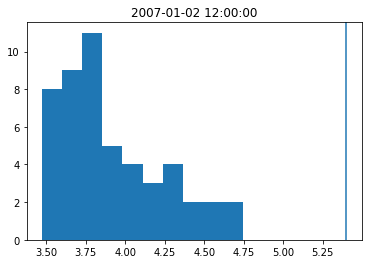

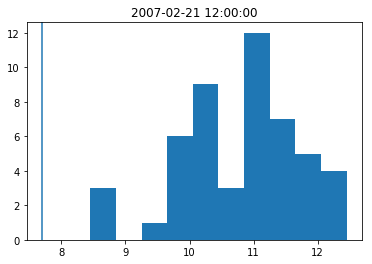

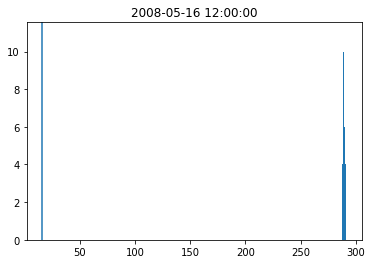

In [36]:
plot_fc_obs_hist(0, 0)
plot_fc_obs_hist(100, 100)
plot_fc_obs_hist(1000, 200)

Ah, ok for years 2008 to 2016, the forecasts are still in K. Let's fix this.

In [37]:
tfc = tfc[:]

array([[[  3.71734357e+00,   4.41180515e+00,   7.29762495e-01, ...,
           2.73963618e+00,   5.49335361e-01,  -8.72639656e-01],
        [  4.00520658e+00,   4.76691961e+00,   1.24904883e+00, ...,
           3.35848475e+00,   1.15464699e+00,  -4.53768402e-01],
        [  4.33275175e+00,   4.43186331e+00,   9.77745235e-01, ...,
           2.25252414e+00,   9.42865491e-01,  -3.81767690e-01],
        ..., 
        [  4.12382364e+00,   4.03059244e+00,   1.34746265e+00, ...,
           3.14612508e+00,   1.45150876e+00,  -3.27126771e-01],
        [  4.58440447e+00,   5.26291990e+00,   1.07061839e+00, ...,
           2.26777697e+00,   1.31817198e+00,  -2.04973474e-01],
        [  3.55579734e+00,   4.43530607e+00,   5.96098185e-01, ...,
           2.90221524e+00,   6.50442421e-01,  -8.58418584e-01]],

       [[  3.70547438e+00,   5.34939146e+00,   1.31507695e+00, ...,
           2.95535469e+00,   1.16953957e+00,  -4.32461083e-01],
        [  3.71610141e+00,   5.00516176e+00,   1.18284655e+0

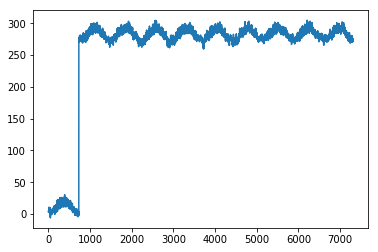

In [40]:
plt.plot(np.mean(tfc, axis=(1, 2)))

In [41]:
np.where(np.mean(tfc, axis=(1, 2)) > 100)

(array([ 730,  731,  732, ..., 7303, 7304, 7305]),)

In [42]:
tfc[730:] = tfc[730:] - 273.15

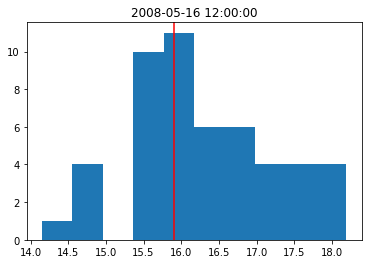

In [45]:
plot_fc_obs_hist(1000, 200)